# [WK] Projekt 1 - Opis obrazu
#### Autorzy: Agnieszka Klimek (145302), Anna Prałat (145395), Daniel Zdancewicz (145317)

## Opis zadania
Śledzenie gry w bilard.
Dla filmów przedstawiających grę w bilard (dowolna odmiana) zaproponuj system:
- Wykrywania bili
- Śledzenia bili
- Wykrywania zdarzeń na filmie
Należy samodzielnie przygotować odpowiednie dane wejściowe.

## Założenia
Jako przyjętą reprezentację obrazu przyjęto filmy gry w snookera z perspektywy ptaka (bird view).
Założono, że kamera jest nieruchoma, a stół do gry jest prostokątem. DOdatkowo założono, że
kamera jest umieszczona nad środkiem stołu, a kąt nachylenia kamery jest równy 90 stopni.

Jako zdarzenia, które są wykrywane na filmie:
- Wbicie bili do łuzy
- Zderzenie bili z drugą bilą


## Technika wykrywania bil na obrazie

1. Wczytanie obrazu
2. Przekształcenie obrazu do skali szarości
3. ???
4. Rozpoznanie 7 masek (po jednej dla każdego koloru bili)
5. Rozpoznanie konturów bili
6. Zapis pozycji zawierających kontury w kolejnych klatkach filmu
7. Zastosowanie prostych równań fizycznych na podstawie pozycji do wyznaczenia pozycji bili w kolejnych klatkach filmu
8. Wykrywanie zdarzeń na podstawie momentum kuli


# Importy

In [2]:
import matplotlib
import PIL
from cv2 import VideoCapture, CAP_PROP_FPS
import cv2
from typing import Iterable
import numpy as np
from numpy import uint8 as u8, int8 as i8
from numpy.typing import NDArray
from dataclasses import dataclass, field
from random import choice
from copy import deepcopy
from sklearn.cluster import KMeans
from skimage.morphology import disk

import warnings

warnings.filterwarnings('ignore')

## Klasy pomocnicze

In [3]:
class Kernel(object):
  @staticmethod
  def sobel_horizontal() -> NDArray[u8]:
    return np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=i8)

  @staticmethod
  def sobel_vertical() -> NDArray[u8]:
    return np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=i8)


In [4]:
def exhaust(iterable: Iterable):
  for _ in iterable: ...


def repeat(value):
  while True: yield value

In [5]:
def imshow(*images):
  try:
    for contents in images:
      if not isinstance(contents, np.ndarray) and isinstance(contents, Iterable):
        imshow(*contents)

    images = [np.array(image).clip(0, 255).astype(u8) for image in images]
    for (i, image) in enumerate(images):
      if image.ndim == 2: images[i] = np.stack([image, image, image], axis=2)
    images = np.concatenate(images, axis=1)

    if images.ndim == 3:
      if images.shape[2] == 4:
        images = cv2.cvtColor(images, cv2.COLOR_BGRA2RGBA)
      else:
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)
    display(PIL.Image.fromarray(images))
  except Exception:
    pass


In [6]:
@dataclass
class Hsv(object):
  h: int
  s: int
  v: int
  name: str | None = None


class BallColor(object):
  @staticmethod
  def similarity(image: NDArray[u8], color_range: tuple[Hsv, Hsv]) -> Hsv:
    (lower, upper) = color_range
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    return cv2.inRange(hsv, np.array([lower.h, lower.s, lower.v]), np.array([upper.h, upper.s, upper.v]))

  @classmethod
  def similarity_rate(cls, image: NDArray[u8], color_range: tuple[Hsv, Hsv]) -> float:
    return np.mean(cls.similarity(image, color_range) - cls.similarity(image, BallColor.backdrop_range))

  @classmethod
  def most_similar(cls, image: NDArray[u8]) -> str:
    return max(cls.colors, key=lambda x: cls.similarity_rate(image, x))[0].name

  @classmethod
  def most_similars(cls, images: Iterable[NDArray[u8]]) -> list[str]:
    return tuple(map(cls.most_similar, images))

  black_range = (Hsv(0, 0, 0, "black or rękaw!"), Hsv(180, 255, 100, "black or rękaw!"))
  white_range = (Hsv(0, 0, 250, "white"), Hsv(180, 255, 255, "white"))
  brown_range = (Hsv(10, 200, 100, 'brown'), Hsv(35, 250, 150, 'brown'))
  yellow_range = (Hsv(30, 100, 100, "yellow or patyk!"), Hsv(35, 255, 255, "yellow or patyk!"))
  blue_range = (Hsv(75, 100, 100, 'blue'), Hsv(100, 255, 255, 'blue'))
  green_range = (Hsv(60, 100, 100, 'green'), Hsv(75, 255, 175, 'green'))
  red_range = (Hsv(0, 150, 100, 'red'), Hsv(20, 255, 255, 'red'))
  pink_range = (Hsv(0, 110, 100, 'pink or łysina!'), Hsv(20, 200, 255, 'pink or łysina!'))
  backdrop_range = (Hsv(45, 100, 100, 'red'), Hsv(60, 255, 255, 'red'))


BallColor.colors = [
  BallColor.black_range,
  BallColor.white_range,
  BallColor.yellow_range,
  BallColor.blue_range,
  BallColor.green_range,
  BallColor.pink_range,
  BallColor.brown_range,
  BallColor.red_range,
]


In [7]:
@dataclass
class VideoInfo(object):
  fps: float
  width: int
  height: int
  dtype: type
  frames: list[NDArray[u8]] = field(default_factory=list)
  timespan: tuple[float, float] = field(default_factory=lambda: (0, 0))

  def __len__(self):
    return len(self.frames)

  @classmethod
  def from_video(cls, video: VideoCapture, timespan: tuple[float, float]):

    width = int(video.get(3))
    height = int(video.get(4))
    fps = video.get(CAP_PROP_FPS)

    start = int(timespan[0] * video.get(CAP_PROP_FPS))
    end = int(timespan[1] * video.get(CAP_PROP_FPS))

    frames = []
    current = 0
    while current < end:
      current += 1
      if current < start: continue
      success, frame = video.read()
      if not success: break
      frames.append(frame)
    video.release()

    dtype = len(frames) > 0 and frames[0].dtype or None
    return cls(fps, width, height, dtype, frames)

  def sample(self):
    return deepcopy(choice(self.frames))

  def __getitem__(self, index):
    if isinstance(index, slice):
      return deepcopy(self.frames[index.start:index.stop:index.step])
    return deepcopy(self.frames[index])


In [8]:
class TransformContext(object):
  def __init__(self, image: NDArray[u8]):
    self.image = image.copy()

  def grayscale(self):
    self.image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
    return self

  def threshold(self, under: int | None = None, over: int | None = None):
    if under is not None: self.image[self.image < under] = 0
    if over is not None: self.image[self.image > over] = 0
    return self

  def threshold_adaptive(self, size: int, c: int):
    self.image = cv2.adaptiveThreshold(self.image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, size, c)
    return self

  def clip_edges(self, size: int):
    self.image[:size, :] = 0
    self.image[-size:, :] = 0
    self.image[:, :size] = 0
    self.image[:, -size:] = 0
    return self

  def dilate(self, kernel: NDArray[i8], iterations: int = 1):
    self.image = cv2.dilate(self.image, kernel, iterations=iterations)
    return self

  def erode(self, kernel: NDArray[i8], iterations: int = 1):
    self.image = cv2.erode(self.image, kernel, iterations=iterations)
    return self

  def opening(self, kernel: NDArray[i8], iterations: int = 1):
    self.image = cv2.morphologyEx(self.image, cv2.MORPH_OPEN, kernel, iterations=iterations)
    return self

  def closing(self, kernel: NDArray[i8], iterations: int = 1):
    self.image = cv2.morphologyEx(self.image, cv2.MORPH_CLOSE, kernel, iterations=iterations)
    return self

  def proper_opening(self, kernel: NDArray[i8]):
    intermediate = cv2.morphologyEx(self.image, cv2.MORPH_OPEN, kernel)
    intermediate = cv2.morphologyEx(intermediate, cv2.MORPH_CLOSE, kernel)
    intermediate = cv2.morphologyEx(intermediate, cv2.MORPH_OPEN, kernel)
    self.image = np.maximum(self.image, intermediate)
    return self

  def proper_closing(self, kernel: NDArray[i8]):
    intermediate = cv2.morphologyEx(self.image, cv2.MORPH_CLOSE, kernel)
    intermediate = cv2.morphologyEx(intermediate, cv2.MORPH_OPEN, kernel)
    intermediate = cv2.morphologyEx(intermediate, cv2.MORPH_CLOSE, kernel)
    self.image = np.minimum(self.image, intermediate)
    return self

  def automedian(self, kernel: NDArray[i8]):
    intermediate = cv2.morphologyEx(self.image, cv2.MORPH_OPEN, kernel)
    intermediate = cv2.morphologyEx(intermediate, cv2.MORPH_CLOSE, kernel)
    intermediate = cv2.morphologyEx(intermediate, cv2.MORPH_OPEN, kernel)
    self.image = np.maximum(intermediate, self.proper_closing(kernel).consume())
    return self

  def mask(self, mask: NDArray[u8], inverse: bool = False):
    mask = mask.copy()
    if inverse: mask = cv2.bitwise_not(mask)
    if len(mask.shape) == 2: mask = np.expand_dims(mask, axis=2)
    self.image = cv2.bitwise_and(self.image, mask)
    return self

  def masks(self, masks: Iterable[NDArray[u8]], inverse: bool = False):
    for mask in masks: self.mask(mask, inverse)
    return self

  def clipped(self, box: tuple[int, int, int]):
    x, y, r = box
    return self.image[y - r:y + r, x - r:x + r]

  def consume(self):
    return self.image.copy()


In [9]:
def calculate_distance(a: tuple[int, int], b: tuple[int, int]) -> int:
  return np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)


class Detection(object):
  @staticmethod
  def disks(image: NDArray[u8], min_distance: int = 1) -> NDArray[tuple[int, int, int]]:
    coordinates = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, 1, min_distance, param1=100, param2=10, minRadius=8,
                                   maxRadius=16)
    if coordinates is None: coordinates = np.array([[]])
    return [tuple(map(int, coordinate)) for coordinate in coordinates[0]]

  @staticmethod
  def edges(image: NDArray[u8]) -> NDArray[tuple[int, int]]:
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    threshold = cv2.adaptiveThreshold(grayscale, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 19, -12)
    lines = cv2.HoughLinesP(threshold, rho=2, theta=np.pi / 20, threshold=600, minLineLength=400, maxLineGap=50)
    lines = lines.squeeze(axis=1)
    return lines

  @staticmethod
  def intersections(edges: NDArray[tuple[int, int]], tolerance: float = 0.1) -> list[tuple[int, int]]:
    def find_intersection(line1, line2):
      xd = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
      yd = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

      def determinant(a, b):
        return a[0] * b[1] - a[1] * b[0]

      det = determinant(xd, yd)
      if det == 0: return None

      d = (determinant(*line1), determinant(*line2))
      x = int(determinant(d, xd) / det)
      y = int(determinant(d, yd) / det)
      return x, y

    intersections = []
    for (x1, y1, x2, y2) in edges:
      for (x3, y3, x4, y4) in edges:
        m1 = abs((y2 - y1) / (x2 - x1))
        m2 = abs((y4 - y3) / (x4 - x3))
        if abs(m1 - m2) > tolerance:
          intersection = find_intersection(((x1, y1), (x2, y2)), ((x3, y3), (x4, y4)))
          if intersection is None: continue
          intersections.append(intersection)
    return intersections

  @staticmethod
  def corners(intersections: Iterable[tuple[int, int]], count: int) -> NDArray[tuple[int, int]]:
    intersections = deepcopy(intersections)
    for intersection in intersections:
      _, y = intersection
      if y < 10: intersections.remove(intersection)

    intersections = np.asarray(intersections).astype(np.float32)
    model = KMeans(n_clusters=count, n_init=10)
    model.fit(intersections)
    segments = model.predict(intersections)
    corners = np.stack([intersections[segments == i].mean(0) for i in range(count)], 0)

    def sorted_corners():
      sums = {
        i: x + y
        for i, (x, y) in enumerate(corners)
      }

      sums = sorted(sums.items(), key=lambda x: x[1])
      items = np.array([corners[s[0]] for s in sums])

      items[3], items[2] = items[2].copy(), items[3].copy()
      return items

    return sorted_corners().astype(int)

  @staticmethod
  def borders(corners: NDArray[tuple[int, int]], tolerance: int = 2) -> NDArray[tuple[int, int]]:
    borders = []
    for first in corners:
      for second in corners:
        if any(first != second) and (
            abs(first[0] - second[0]) < tolerance or abs(first[1] - second[1]) < tolerance):
          borders.append((first, second))

    return np.array(borders)

  @staticmethod
  def oversized(image: NDArray[u8], size: int = 4200) -> Iterable[NDArray[u8]]:
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    oversized = []
    for contour in contours:
      if cv2.contourArea(contour) <= size: continue
      mask = np.zeros(image.shape[:2])
      mask = cv2.drawContours(mask.copy(), [contour], -1, (255, 0, 0), -1)
      oversized.append(TransformContext(mask).dilate(kernel, 2).closing(kernel).consume().astype(u8))
    return oversized

  @staticmethod
  def holes(corners: list[tuple[int, int]]):
    topleft = min(corners, key=lambda x: (x[0], x[1]))
    topright = max(corners, key=lambda x: (x[0], -x[1]))
    bottomleft = min(corners, key=lambda x: (-x[1], x[0]))
    bottomright = max(corners, key=lambda x: (x[1], x[0]))

    return [
      topleft,
      topright,
      bottomleft,
      bottomright,
      ((topleft[0] + topright[0]) // 2, topleft[1]),
      ((bottomleft[0] + bottomright[0]) // 2, bottomleft[1]),
    ]

  @classmethod
  def near(cls, coordinates: list[tuple[int, int]], of: tuple[int, int], radius: int) -> list[tuple[int, int]]:
    return [coordinate for coordinate in coordinates if cls.is_near(coordinate, of, radius)]

  @staticmethod
  def is_near(a: tuple[int, int], b: tuple[int, int], radius: int) -> bool:
    return np.sqrt((int(a[0]) - int(b[0])) ** 2 + (int(a[1]) - int(b[1])) ** 2) <= int(radius)


In [10]:
class DrawContext(object):
  def __init__(self, image: NDArray[u8], coordinates: Iterable[tuple[int, int, int]] = None):
    self.image = image.copy()
    self.coordinates = coordinates
    if self.coordinates is None: self.coordinates = []

  def points(self, coordinates: Iterable[tuple[int, int, int]] = None):
    coordinates = coordinates if coordinates is not None else self.coordinates
    for (x, y, _) in coordinates:
      cv2.circle(self.image, (x, y), 4, (255, 0, 0), -1)
    return self

  def boxes(self, coordinates: Iterable[tuple[int, int, int]] = None):
    coordinates = coordinates if coordinates is not None else self.coordinates
    for (x, y, z) in coordinates:
      cv2.rectangle(self.image, (x - 16, y - 16), (x + 16, y + 16), (255, 0, 0), 2)
    return self

  def disks(self, coordinates: Iterable[tuple[int, int, int]] = None):
    coordinates = coordinates if coordinates is not None else self.coordinates
    for (x, y, z) in coordinates:
      cv2.circle(self.image, (x, y), z, (0, 0, 255), -1, cv2.LINE_AA)
    return self

  def circle(self, coordinate: tuple[int, int], size: int, color: tuple[int, int, int] = (0, 0, 255)):
    (x, y) = coordinate
    cv2.circle(self.image, (x, y), size, color, 2, cv2.LINE_AA)
    return self

  def lines(self, lines: NDArray[tuple[int, int]], size=5):
    for first, second in lines:
      cv2.line(self.image, first, second, (255, 0, 0), size, cv2.LINE_AA)
    return self

  def label(self, label: str, at: tuple[int, int, int], *, size=1):
    (x, y, z) = at
    (label_x, label_y) = cv2.getTextSize(label, 5, 1, size)[0]
    label_x = x - label_x // 2
    label_y = y + label_y // 2

    cv2.putText(self.image, label, (label_x, label_y + z + 5), 5, 1, (255, 235, 255), size, cv2.LINE_AA)
    return self

  def labels(self, labels: list[str], at: list[tuple[int, int, int]]):
    exhaust(map(self.label, labels, at))
    return self

  def consume(self):
    return self.image.copy()


## Wczytanie filmu

In [11]:
video: VideoInfo = None

In [12]:
match = VideoCapture('resources/matches/match-1-topdown-view.mp4')

if video is None:
  video = VideoInfo.from_video(match, (0, 5))

## Prezentacja parametrów filmu


Video info:
  FPS    : 25.0
  Width  : 1280
  Height : 720
  Frame  : 125
  d-type : uint8



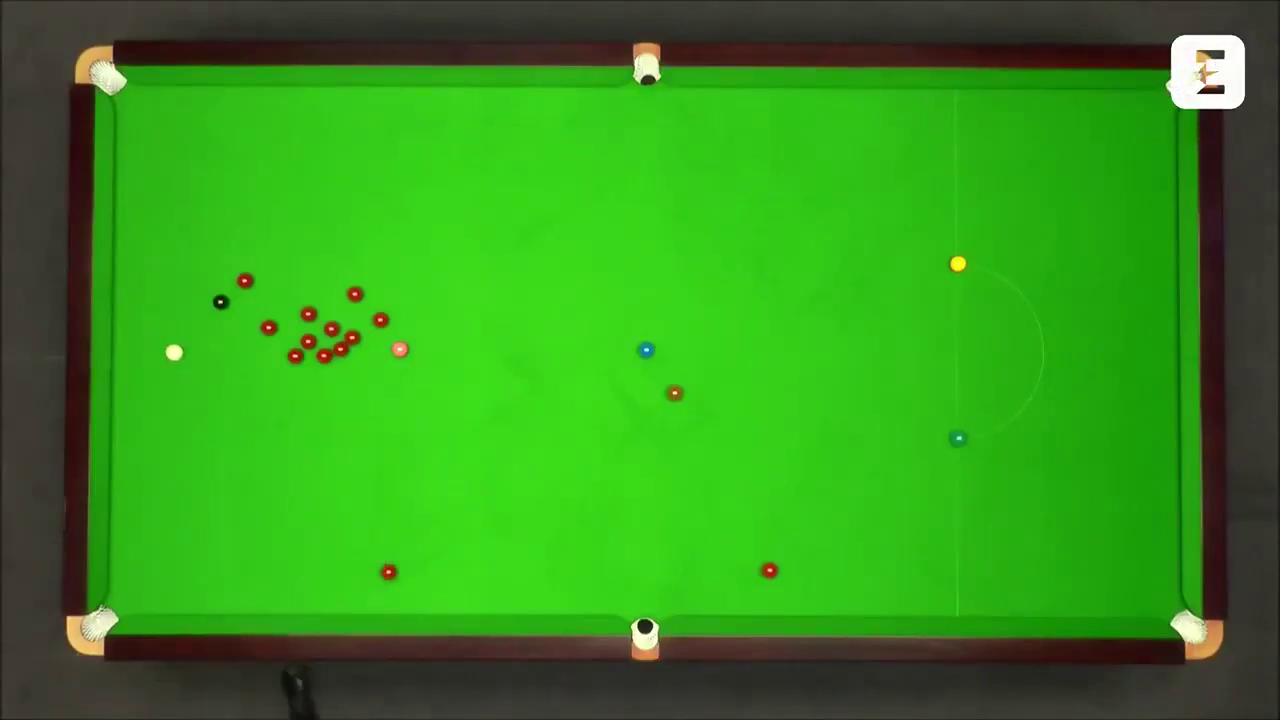

In [13]:
print(f"""
Video info:
  FPS    : {video.fps}
  Width  : {video.width}
  Height : {video.height}
  Frame  : {len(video)}
  d-type : {video.dtype}
""")

imshow(video.sample())

## Wykrywanie krawędzi stołu

In [14]:
def fft(image: NDArray[u8], size: Iterable[int] | None = None) -> tuple[NDArray[u8], int]:
  frequencies = np.fft.fft2(image, size)
  shift = np.fft.fftshift(frequencies)
  spectrum = 20 * np.log(np.abs(shift))
  return shift, spectrum


def ifft(shift: NDArray[u8]) -> NDArray[u8]:
  inverse = np.fft.ifftshift(shift)
  image = np.fft.ifft2(inverse)
  return np.real(image)


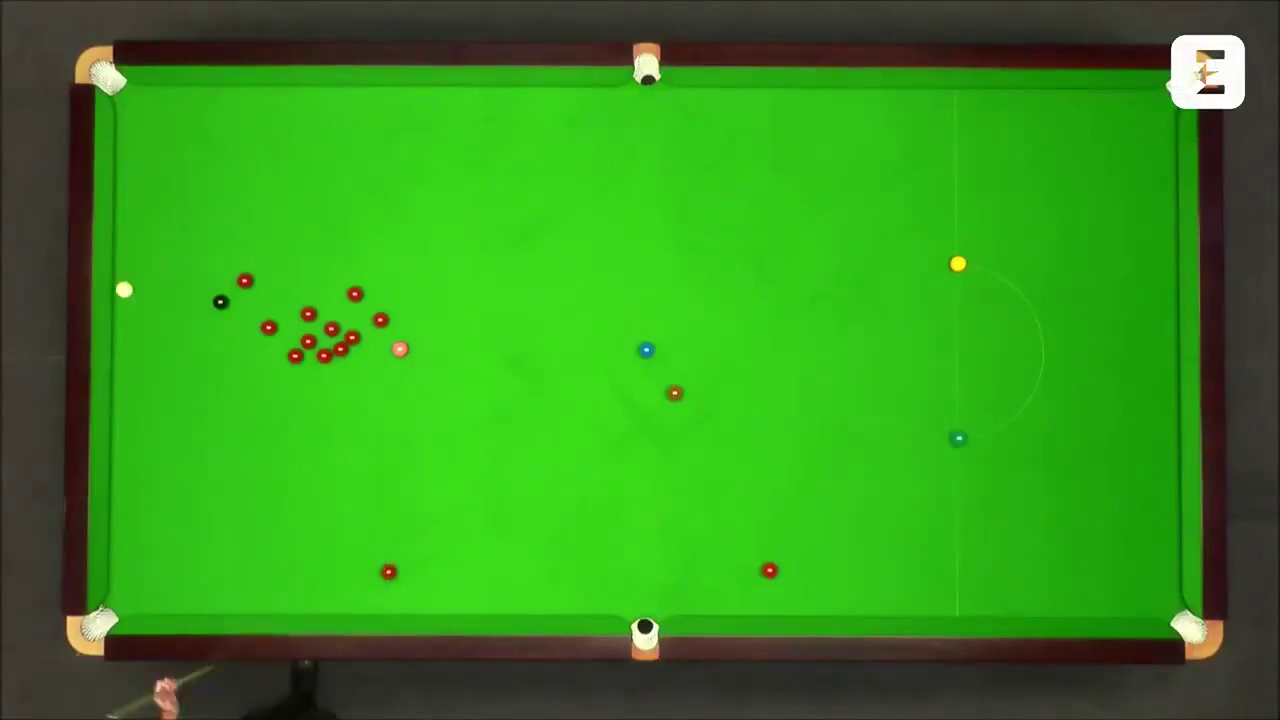

In [15]:
image = video.frames[50]

imshow(image)

In [16]:
def create_table_mask(image: NDArray[u8], corners: NDArray[tuple[int, int]]):
  grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  threshold = cv2.adaptiveThreshold(grayscale, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 19, -12)
  table_mask = cv2.fillConvexPoly(np.zeros_like(threshold) + 255, corners, 1)

  # apply extra 10 pixels inset
  table_mask = cv2.dilate(table_mask, np.ones((60, 30), np.uint8), iterations=1)
  num_rows, num_cols = table_mask.shape[:2]
  table_mask = 255 - table_mask
  translation_matrix = np.float32([[1, 0, 0], [0, 1, 0]])
  table_mask = cv2.warpAffine(table_mask, translation_matrix, (num_cols, num_rows))
  table_mask = 255 - table_mask
  return table_mask


## Obróbka obrazu do wykrywania bili

In [17]:
def magnify_objects(image: NDArray[u8], table_mask: NDArray[u8]) -> NDArray[u8]:
  grayscale = TransformContext(image).grayscale().consume()
  vertical_kernel = Kernel.sobel_vertical()
  horizontal_kernel = Kernel.sobel_horizontal()

  shift, _ = fft(grayscale)
  vertical_shift, _ = fft(vertical_kernel, image.shape[:2])
  horizontal_shift, _ = fft(horizontal_kernel, image.shape[:2])

  vertical = ifft(shift * vertical_shift)
  horizontal = ifft(shift * horizontal_shift)

  return (TransformContext(np.sqrt(vertical ** 2 + horizontal ** 2).astype(u8))
          .dilate(np.ones((3, 3)), 2)
          .erode(np.ones((3, 3)), 1)
          .threshold(50)
          .proper_opening(np.ones((16, 16)))
          .automedian(np.ones((3, 3)))
          .mask(table_mask, True)
          .consume())


## Przedstawienie transformacji dokonywanych na klatkach filmu

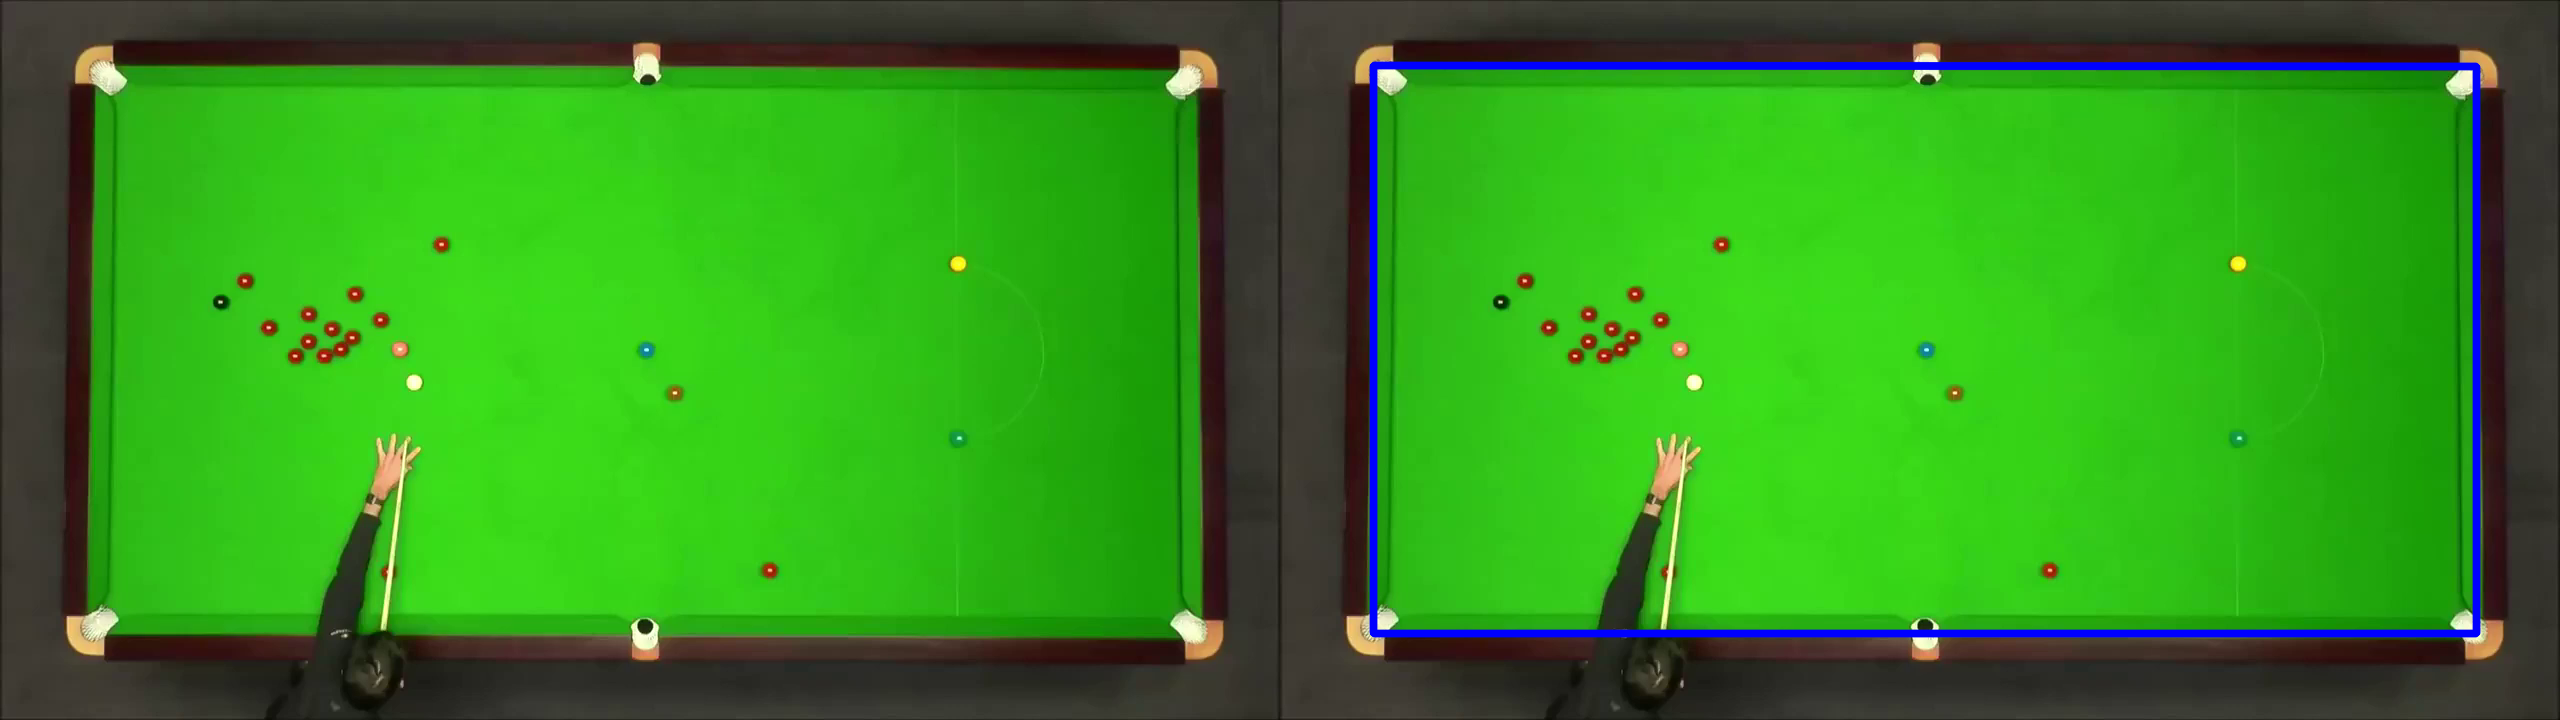

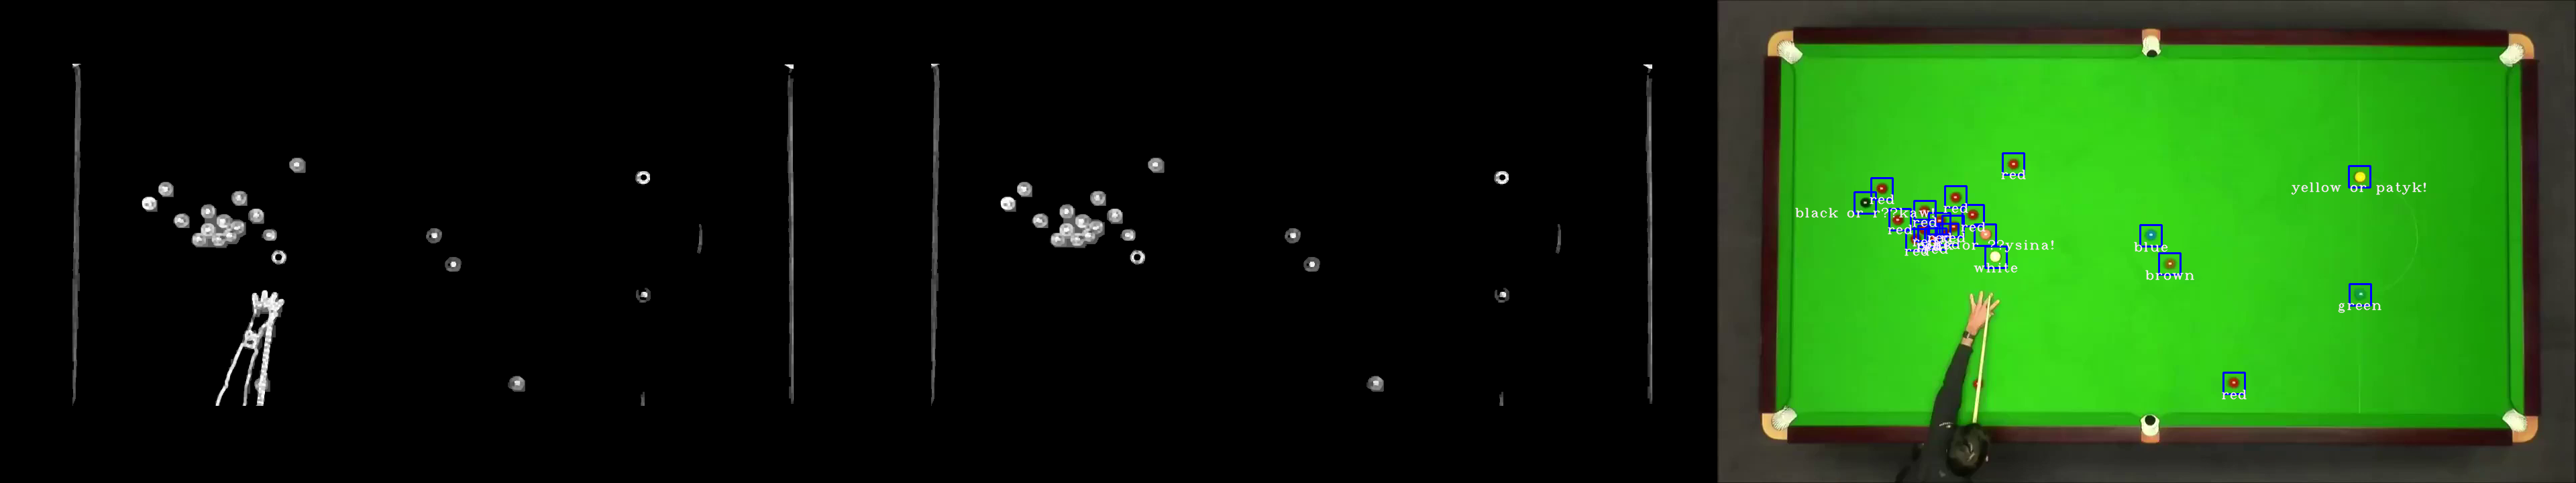

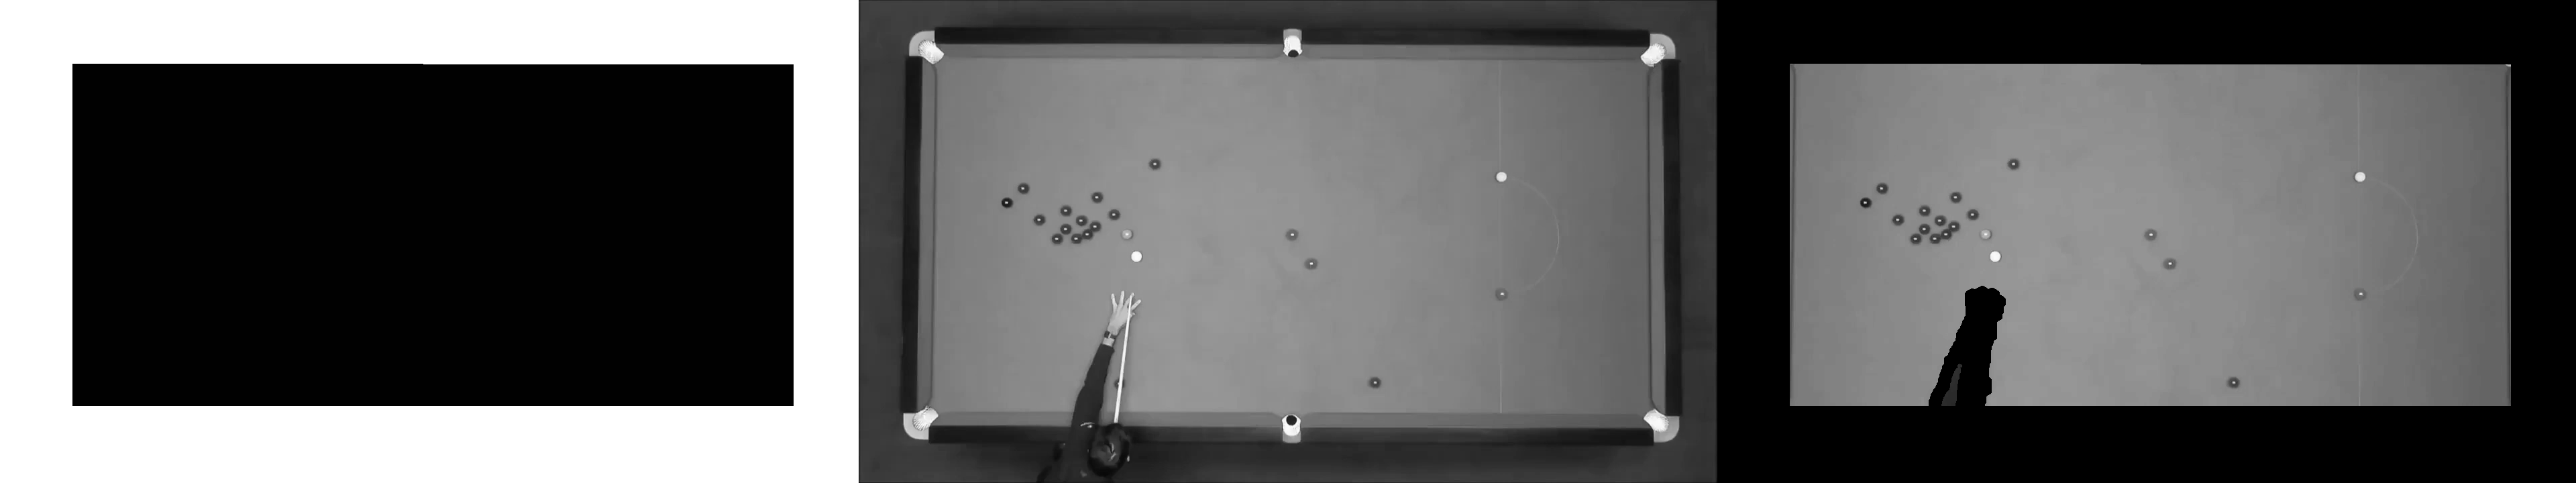

In [18]:
image = video[0]
edges = Detection.edges(image)
intersections = Detection.intersections(edges, tolerance=0.1)
corners = Detection.corners(intersections, 4)
borders = Detection.borders(corners)

table_mask = create_table_mask(image, corners)
magnified = magnify_objects(image, table_mask)
masks = Detection.oversized(magnified, 4500)

context = TransformContext(magnified)
for mask in masks: context.mask(mask, inverse=True)
cleared = context.consume()
coordinates = Detection.disks(cleared, 10)

labels = BallColor.most_similars(map(TransformContext(image).clipped, coordinates))
labeled = DrawContext(image).boxes(coordinates).labels(labels, coordinates).consume()

imshow(
  [image, DrawContext(image).lines(borders).consume()],
  [magnified, cleared, labeled],
  [
    table_mask,
    grayscale := TransformContext(image).grayscale().consume(),
    TransformContext(grayscale).mask(table_mask, inverse=True).mask(mask, inverse=True).consume()
  ]
)

## Przygotowanie klatek do wykrywania bili

In [19]:
@dataclass
class FrameInfo(object):
  annotations: Iterable[tuple[str, tuple[int, int, int], NDArray[u8]]]
  mask: NDArray[u8]
  image: NDArray[u8]


class Tracker(object):
  def __init__(self, video: VideoInfo):
    self.table_mask: NDArray[u8] = None
    self.video = video
    self.i = -1

  def __iter__(self):
    return self

  def __next__(self):
    self.i += 1
    return self.prepare()

  def prepare(self):
    frame = self.video[self.i]
    print(self.i)
    if self.table_mask is None:
      edges = Detection.edges(frame)
      intersections = Detection.intersections(edges, tolerance=0.1)
      corners = Detection.corners(intersections, 4)

      self.table_mask = create_table_mask(frame, corners)

    magnified = magnify_objects(frame, self.table_mask)

    context = TransformContext(magnified)
    for mask in Detection.oversized(magnified, 3500):
      context.mask(mask, inverse=True)
    mask = context.consume()
    coordinates = Detection.disks(mask, 10)

    clips = tuple(map(TransformContext(frame).clipped, coordinates))
    labels = BallColor.most_similars(clips)

    return FrameInfo(
      tuple(zip(labels, coordinates, clips)),
      mask,
      frame
    )


class FrameInfoMethods(object):
  @staticmethod
  def draw(frame: FrameInfo):
    labels, coordinates, _ = zip(*frame.annotations)

    return DrawContext(frame.image).boxes(coordinates).labels(labels, coordinates).consume()

  @staticmethod
  def find(frame: FrameInfo, color: str):
    if frame.annotations is None: return []
    matching = tuple(filter(lambda x: x[0] == color, frame.annotations))
    print(len(matching))


In [20]:
@dataclass
class BallPositions(object):
  red: Iterable[tuple[int, int]] = field(default_factory=list)
  yellow: tuple[int, int] | None = None
  green: tuple[int, int] | None = None
  brown: tuple[int, int] | None = None
  blue: tuple[int, int] | None = None
  pink: tuple[int, int] | None = None
  black: tuple[int, int] | None = None
  white: tuple[int, int] | None = None


@dataclass
class MatchMemory(object):
  positions: BallPositions = field(default_factory=BallPositions)



In [21]:
import itertools


def take(it, count):
  return tuple(itertools.islice(it, count))


tracker = iter(Tracker(video))
frames = take(tracker, 100)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [24]:
import time
from collections import defaultdict


def track(frames: Iterable[FrameInfo], color: str) -> Iterable[tuple[int, int]]:
  history = []
  for i, frame in enumerate(frames):
    candidates = tuple(filter(lambda x: x[0] == color, frame.annotations))

    if not candidates and history:
      candidate = history[-1]
    elif len(candidates) > 1:
      candidates = [min(candidates, key=lambda m: calculate_distance(history[-1], m[1]))]
      candidate = candidates[0][1]
    else:
      candidate = candidates[0][1]

    history.append([int(candidate[0]), int(candidate[1])])

  return [coordinate for coordinate in history]


def find_near_whites_per_frame(frames: Iterable[FrameInfo], whites: Iterable[tuple[int, int]], radius: int):
  near = []
  for i, (white, frame) in enumerate(zip(whites, frames)):
    level = defaultdict(list)
    candidates = tuple(filter(lambda x: x[0] != 'white', frame.annotations))
    for (color, location, _) in candidates:
      if Detection.is_near(white, location, radius):
        level[color].append((int(location[0]), int(location[1])))
    near.append(level)
  return near


def find_near_holes(frames: Iterable[FrameInfo], holes: Iterable[tuple[int, int]], radius: int) -> dict[
  str, list[tuple[int, int]]]:
  near = []
  for i, frame in enumerate(frames):
    level = defaultdict(list)
    candidates = frame.annotations
    for (color, location, _) in candidates:
      for hole in holes:
        if Detection.is_near(hole, location, radius):
          level[color].append((int(location[0]), int(location[1])))
    near.append(level)
  return near


def find_maybe_potted(frames: Iterable[FrameInfo], holes: Iterable[tuple[int, int]], radius_closer: int,
                      radius_further: int, patience: int, visualize: bool = False):
  closer = find_near_holes(frames, holes, radius_closer)
  furthers = find_near_holes(frames, holes, radius_further)

  results = []
  for i in range(patience, len(closer) - patience):
    close = closer[i]
    frame = frames[i]

    for (color, locations) in close.items():
      for location in locations:
        hole = min(holes, key=lambda hole: calculate_distance(location, hole))
        distance = calculate_distance(location, hole)

        c = DrawContext(frame.image)
        c.circle(hole, radius_closer, (0, 255, 0))
        c.circle(hole, radius_further, (0, 0, 255))
        for h in locations: c.circle(h, 10)

        before_counts = []
        before = furthers[i - patience:i]
        for step in before:
          if not color in step: continue

          step = step[color]
          for index, loc in enumerate(step):
            if distance < calculate_distance(loc, hole) <= radius_further: continue
            step.pop(index)
          before_counts.append(len(step))

          if not visualize: continue
          for h in step:
            c.circle(h, 10, (0, 255, 255))

        after = furthers[i + 1:i + patience + 1]

        after_counts = []
        for step in after:
          if not color in step: continue

          step = step[color]
          for index, loc in enumerate(step):
            if distance > calculate_distance(loc, hole) <= radius_further: continue
            step.pop(index)
          after_counts.append(len(step))

          if not visualize: continue
          for h in step:
            c.circle(h, 10, (255, 255, 0))

        if visualize: imshow(c.consume())

        if sum(before_counts) >= patience:
          results.append((i, color, location, hole))
  return results


def save_as_movie(frames: Iterable[NDArray[u8]], filename: str):
  video = cv2.VideoWriter(f"{filename}.mp4", cv2.VideoWriter_fourcc(*'mp4v'), 15, (1280, 720))
  for frame in frames: video.write(frame)
  cv2.destroyAllWindows()
  video.release()


def capture():
  image = video[0]
  edges = Detection.edges(image)
  intersections = Detection.intersections(edges, tolerance=0.1)
  corners = Detection.corners(intersections, 5)

  radius = 100
  whites = track(frames, 'white')
  near_whites = find_near_whites_per_frame(frames, whites, radius)

  holes = Detection.holes(corners)
  near_holes = find_near_holes(frames, holes, radius)

  closer = 100
  further = 140
  maybe_pots = find_maybe_potted(frames, holes, closer, further, 2)
  cooldown_max = 50
  cooldown = 0
  display_for_max = 50
  display_who = None
  display_for = 0

  captures = []
  for (i, frame, white, white_nearby, hole_nearby) in zip(range(len(frames)), frames, whites, near_whites, near_holes):

    context = DrawContext(frame.image)

    cooldown -= 1
    display_for -= 1
    print(f"Frame: {i}")
    if cooldown < 0:
      for pot in maybe_pots:
        if pot[0] != i: continue
        cooldown = cooldown_max
        display_for = display_for_max
        display_who = pot[1]

    if display_for > 0:
      middle_x = video.width // 2
      middle_y = video.height // 2
      context.label(f"Potted!: {display_who}", (middle_x, middle_y, 15), size=2)

    for hole in holes: context.circle(hole, radius)

    for color, candidates in white_nearby.items():
      for candidate in candidates:
        context.circle(candidate, radius, (128, 128, 128))

    for color, candidates in hole_nearby.items():
      for candidate in candidates:
        context.circle(candidate, radius, (255, 0, 255))

    context.circle(white, radius)
    captures.append(context.consume())
  save_as_movie(captures, 'potings')


def calculate_trajectory(history: list[tuple[int, int]]):
  trajectory = list(history)

  for i in reversed(range(len(trajectory) - 1)):
    a, b = trajectory[i], trajectory[i + 1]
    if np.all(a != b): continue
    trajectory.pop(i)

  return trajectory


def within_radius(a, b, radius):
  return calculate_distance(a, b) <= radius


# Parameters for lucas kanade optical flow
lk_params = dict(
  winSize=(15, 15),
  maxLevel=2,
  criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
)


def find_hit_detections(frames: Iterable[FrameInfo], radius: int, patience: int):
  # for frame_i in range(patience, len(frames) - patience):
  #   current = frames[frame_i]
  #   next = frames[frame_i + 1]
  #
  #   cur = [(color, location[:2]) for annotation in current.annotations for (color, location) in [annotation[:2]]]
  #   ne = [(color, location[:2]) for annotation in next.annotations for (color, location) in [annotation[:2]]]
  #
  #   potential_movement = []
  #
  #   for i, a in enumerate(cur):
  #     for j, b in enumerate(ne):
  #       if a[0] != b[0]: continue
  #       distance = calculate_distance(a[1], b[1])
  #       if distance <= 5: continue
  #       if distance >= radius: continue
  #       print(calculate_distance(a[1], b[1]))
  #       potential_movement.append((i, j, a, b))
  #
  #   if not potential_movement: continue
  #
  #   c = DrawContext(current.image)
  #   for (i, j, a, b) in potential_movement:
  #     c.circle(a[1], 20, (0, 255, 0))
  #     c.circle(b[1], 20, (0, 255, 255))
  #   imshow(c.consume())
  #   break
  # Get a VideoCapture object from video and store it in vs

  # Read first frame
  # Scale and resize image

  first_frame = frames[0].image
  prevgray = frames[0].mask

  p0 = np.array([[int(location[0]), int(location[1])] for annotation in frames[0].annotations for (color, location) in [annotation[:2]]],dtype=np.float32)
  p0 = p0.reshape(-1, 1, 2)

  mask = np.zeros_like(first_frame)
  lk_params = dict(winSize=(15, 15), maxLevel=3, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

  for frame_ in frames[1:]:
    frame = frame_.image
    gray = frame_.mask

    p1, st, err = cv2.calcOpticalFlowPyrLK(prevgray, gray, p0, None, **lk_params)

    good_new = p1[st == 1]
    good_old = p0[st == 1]

    for i, (new, old) in enumerate(zip(good_new, good_old)):
      a, b = new.ravel()
      c, d = old.ravel()
      mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), (0, 0, 255), 2)
      frame = cv2.circle(frame, (int(a), int(b)), 5, (0, 0, 255), -1)
    img = cv2.add(frame, mask)

    cv2.imshow('123123', img)

    # Now update the previous frame and previous points
    prevgray = gray.copy()
    p0 = good_new.reshape(-1, 1, 2)

    if cv2.waitKey(10) & 0xFF == ord('q'): break
    time.sleep(0.1)

  cv2.destroyAllWindows()


# capture()
# print('saved')

find_hit_detections(frames, 20, 1)

# white_frames = [
#   DrawContext(frame.image).circle(coordinate, 80).consume()
#   for (frame, coordinate) in zip(frames, white_history)
# ]
# save_as_movie(white_frames, 'white-history')
# save_as_movie(map(FrameInfoMethods.draw, frames), 'classification')
